In [1]:
# Example Exercise MBDPT Instacart
# The Instacart Online Grocery Shopping Dataset 2017
# Accessed from https://www.instacart.com/datasets/grocery-shopping-2017 on 15 January 2024
# Read : https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2
# Read : https://www.instacart.com/company/how-its-made/how-instacart-uses-embeddings-to-improve-search-relevance/
# See : https://towardsdatascience.com/creating-a-grocery-product-recommender-for-instacart-c1b6bdf5ae13

In [2]:
#importing libraries
import pandas as pd
import numpy as np

import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import itertools

from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Importing INSTACART datasets
# Downloaded froom https://www.kaggle.com/c/instacart-market-basket-analysis
# Metadata in https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b

orders = pd.read_csv("./data/orders.csv")
products = pd.read_csv("./data/products.csv")
aisles = pd.read_csv("./data/aisles.csv")
departments = pd.read_csv("./data/departments.csv")
# order_products_ corresponds to the baskets. It is divided in 3 sets, prior (orders in the past) train (last order)
# and test (for the Kaggle submission) we will not use test for this exercise
order_products_prior = pd.read_csv("./data/order_products__prior.csv")
order_products_train = pd.read_csv("./data/order_products__train.csv")

In [14]:
order_products_train

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1



The dataset is divided into 3 parts Priors, Train, and Test. Prior orders contain information about users 
and their previous orders. The train and test orders will be used for the training and testing of the model. 
These prior orders will be used for feature engineering. There are almost 50K products and about 3M orders. 
Also, there is a chance that users might or may not order products that were a part of previous orders. 
Thus ‘None’ can also be an answer to the user’s next purchase. Therefore, we will have to consider ‘None’ as a 
separate product.

See : https://medium.com/geekculture/kaggle-instacart-market-basket-analysis-8bfbbf5f2efb


In [5]:
order_products_prior.shape

(32434489, 4)

In [8]:
print(orders.shape, orders.columns)

(3421083, 7) Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')


In [6]:
order_products_train.shape

(1384617, 4)

In [4]:
# Files Content analysis

In [5]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [6]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [7]:
# Unique values as per file
print("Number of unique product_id: ", products.product_id.nunique())
print("Number of unique department_id: ", products.department_id.nunique())
print("Number of unique aisle_id: ", products.aisle_id.nunique())

Number of unique product_id:  49688
Number of unique department_id:  21
Number of unique aisle_id:  134


**Contents**

- **product_id**: There are 49,688 products in the dataset. 
- **product_name**: name of the product
- **aisle_id**: There are a total of 134 aisles in the dataset.
- **department_id**: There are a total of 21 departments in the dataset.

Don't have null values

In [8]:
# departments

In [9]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [10]:
departments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes


In [11]:
# aisles

In [12]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [13]:
aisles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [14]:
# orders

In [15]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [16]:
order_products_prior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB


In [17]:
#Unique values
print("Number of unique order_id: ", order_products_prior.order_id.nunique())
print("Number of unique product_id: ", order_products_prior.product_id.nunique())
print("Number of unique add_to_cart_order: ", order_products_prior.add_to_cart_order.nunique())

Number of unique order_id:  3214874
Number of unique product_id:  49677
Number of unique add_to_cart_order:  145


In [18]:
#Print the smallest and largest order_id
print("Smallest order_id: ", order_products_prior.order_id.min())
print("Largest order_id: ", order_products_prior.order_id.max())

Smallest order_id:  2
Largest order_id:  3421083


Insights:

- We have **32,434,489 rows** in the dataset. Despite that, each row **is not representing a single order**. Instead, each row represents a **product** in an order.
- The **order_id** ranks from id 2, to id 3,421,083. As we just have 3,214,874 unique orders, we can conclude that some orders id are not in the dataset. Specifically, **206,209 orders that are inside the lowest and highest id are not included in this dataset**.
- We have **3,214,874 unique orders** in the dataset. That's a lot of orders!
- Regarding the **product_id**, we have **49,677 products** that have been order, but we have **49,688 products** in the products dataset. That could mean that **11 products have never been ordered**. Could we already save some space to Instacart by removing them from the products dataset? We will have to merge with train to check it
- The **add_to_cart_order** column contains the order in which each product has been added to the cart. The maximum order size is of 145 products.
- The **reordered** column indicates whether the product has been reordered or not. 

In [19]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [20]:
order_products_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int64
 1   product_id         1384617 non-null  int64
 2   add_to_cart_order  1384617 non-null  int64
 3   reordered          1384617 non-null  int64
dtypes: int64(4)
memory usage: 42.3 MB


In [21]:
#Count unique values in each column
print("Number of unique order_id: ", order_products_train.order_id.nunique())
print("Number of unique product_id: ", order_products_train.product_id.nunique())
print("Number of unique add_to_cart_order: ", order_products_train.add_to_cart_order.nunique())

Number of unique order_id:  131209
Number of unique product_id:  39123
Number of unique add_to_cart_order:  80


In [22]:
#Print the smallest and largest order_id
print("Smallest order_id: ", order_products_train.order_id.min())
print("Largest order_id: ", order_products_train.order_id.max())

Smallest order_id:  1
Largest order_id:  3421070


Quite the same insights structure than in the order_products_prior dataset, but with some differences:
- We have **1,384,617 rows** in the dataset. Despite that, each row **is not representing a single order**. Instead, each row represents a **product** in an order.
- The total number of orders is **131,209**. And they rank from id 1 to order id 3,421,083. Adding this to the order_products_prior dataset, we can conclude that, yet, we are missing **75,000 orders** (they probably are the ones in sample submission)
- The number of unique products is **39,123**
- The maximum order size is of 80 products.


In [23]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


Note: order_dow is the day of the week

In [24]:
orders.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


In [25]:
orders.isnull().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [26]:
#Get the unique values of order_number when days_since_prior_order is null
orders[orders.days_since_prior_order.isnull()].order_number.unique()

array([1], dtype=int64)

In [27]:
#Get the unique values of each column
print("Number of unique order_id: ", orders.order_id.nunique())
print("Number of unique user_id: ", orders.user_id.nunique())
print("Number of unique order_number: ", orders.order_number.nunique())

Number of unique order_id:  3421083
Number of unique user_id:  206209
Number of unique order_number:  100


In [28]:
#For column eval_set, check the number of unique values in each set and a count of their appearances
print("Number of unique eval_set: ", orders.eval_set.nunique())
print("Number of unique eval_set: ", orders.eval_set.value_counts())


Number of unique eval_set:  3
Number of unique eval_set:  eval_set
prior    3214874
train     131209
test       75000
Name: count, dtype: int64


Regarding the orders dataset:

- It contains the **user_id** and the **orders** (with time information) make but each user but it does not disaggregate the contained products, so we will have to merge with the other orders dataset
- When the **order is a new one, days_since_prior_order is null.** We have seen that we have 206,209 new orders, which is the same number of user ids, so **we are not missing past data about any user.**
- The test dataset contains 75,000 orders, which is the same number of orders that we are missing in the orders dataset. So, we can conclude our previous hypothesis, that the orders in the test dataset are the ones that are missing in the orders dataset. Also, **the amount of records in prior and train coincide with the amount of records in the orders datasets previously analized**

**We have to be aware at this point that, the last order that each user has made, will be in the train or in the test datasets, while the previous ones will be in the prior dataset.**

What is clear now is that, for deep analysis, we will have to merge the datasets. So let's do it!

In [29]:
# customers orders day of week
orders_dow = orders['order_dow'].value_counts()
orders_dow

order_dow
0    600905
1    587478
2    467260
5    453368
6    448761
3    436972
4    426339
Name: count, dtype: int64

In [30]:
orders['order_dow']

0          2
1          3
2          3
3          4
4          4
          ..
3421078    5
3421079    4
3421080    1
3421081    1
3421082    6
Name: order_dow, Length: 3421083, dtype: int64

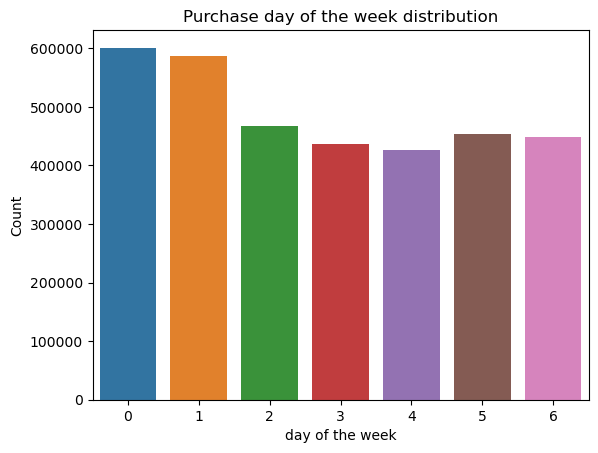

In [31]:
plt.figure()
sns.countplot(orders, x='order_dow')
plt.title("Purchase day of the week distribution")
plt.xlabel("day of the week")
plt.ylabel("Count")
plt.show()

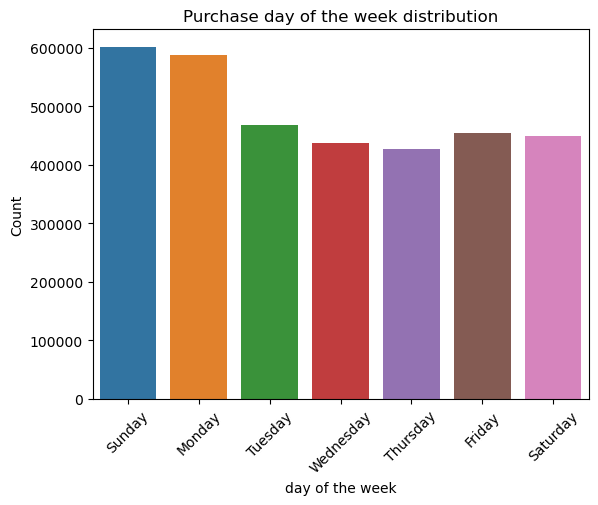

In [32]:
# The figure looks so so a trick to have the name of the days using a list (careful 0 is sunday)
# Remember, spend time making your visualizations as nice as possible
d_o_w_list = ['Sunday', 'Monday', 'Tuesday','Wednesday','Thursday', 'Friday', 'Saturday']
fig, ax = plt.subplots()
sns.countplot(orders, x='order_dow')
plt.title("Purchase day of the week distribution")
plt.xlabel("day of the week")
plt.ylabel("Count")
ax.set_xticklabels(d_o_w_list, rotation=45)
plt.show()

In [33]:
#First, we will divide the orders into 2 sets: prior and train in one dataframe and test in another
orders_info = orders[orders.eval_set != "test"]
orders_test = orders[orders.eval_set == "test"]

In [34]:
#We will replace the days_since_prior_order null values with 0 and we will convert the column to int and order_id and user_id to object
orders_info.days_since_prior_order.fillna(0, inplace=True)
orders_info.days_since_prior_order = orders_info.days_since_prior_order.astype(int)
orders_info.order_id = orders_info.order_id.astype(object)
orders_info.user_id = orders_info.user_id.astype(object)

In [35]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


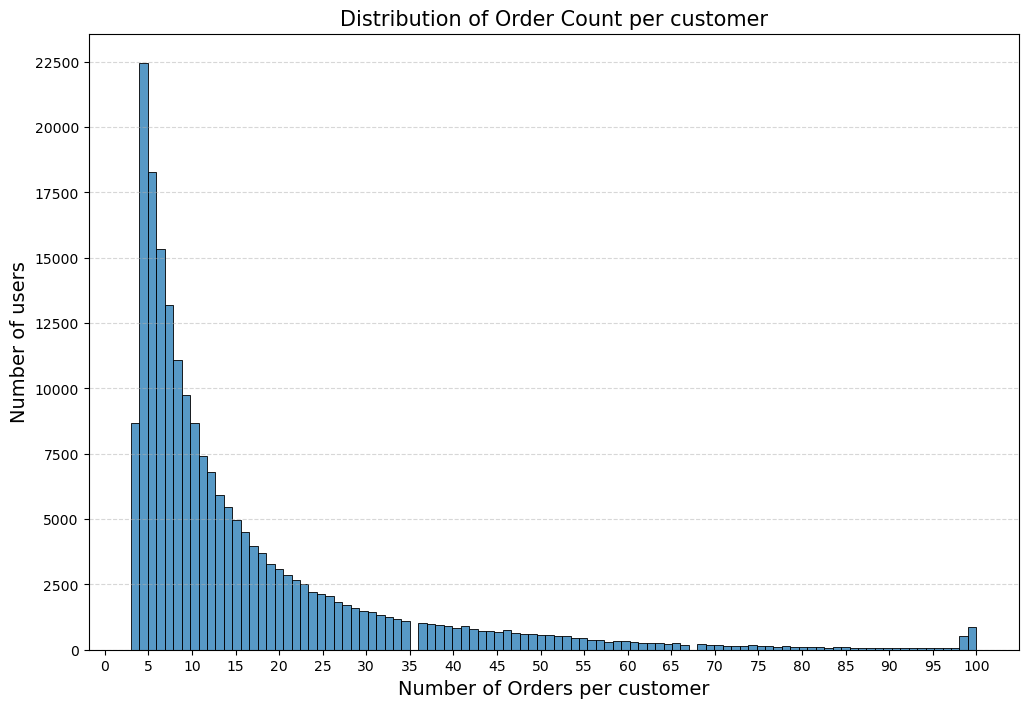

In [36]:
#Now, we will check how many orders each user has made, plotting a histogram

products_per_user = orders_info.groupby('user_id')['order_id'].count()

plt.figure(figsize=(12, 8))
sns.histplot(products_per_user, bins=100)

plt.xlabel('Number of Orders per customer', fontsize=14)
plt.ylabel('Number of users', fontsize=14)
plt.title("Distribution of Order Count per customer", fontsize=15)
plt.xticks(np.arange(0, 105, 5), fontsize=10)
plt.yticks(np.arange(0, 25000, 2500), fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

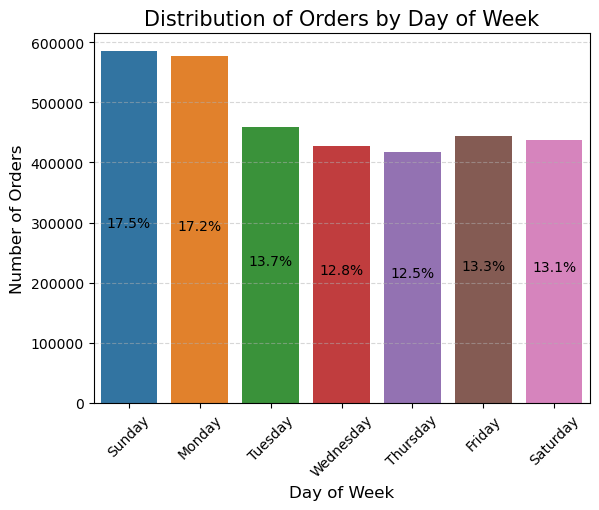

In [37]:
#Let's print a graph with how orders have been distributed over weekdays
orders_per_dow = orders_info['order_dow'].value_counts().sort_index()

fig, ax = plt.subplots()
sns.barplot(x=orders_per_dow.index, y=orders_per_dow.values)

plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.title('Distribution of Orders by Day of Week', fontsize=15)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

#Add a percentage label to each bar a trick to make the visuals more informative
for i in range(len(orders_per_dow)):
    count = orders_per_dow[i]
    pct_string = '{:0.1f}%'.format(100*count/orders_per_dow.sum())
    plt.text(i, count/2, pct_string, ha='center', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.5)
ax.set_xticklabels(d_o_w_list, rotation=45)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

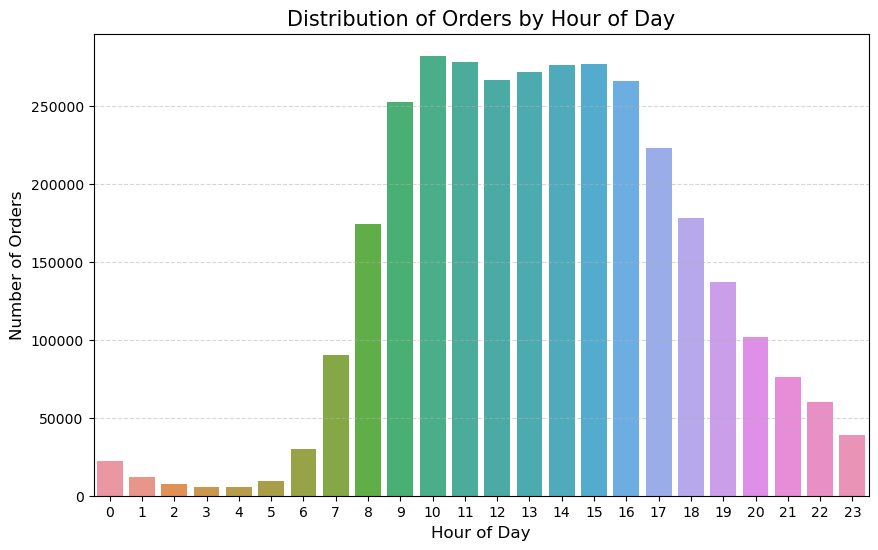

In [38]:
#Now, we will print a graph with how orders have been distributed over hours
orders_per_hour = orders_info['order_hour_of_day'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=orders_per_hour.index, y=orders_per_hour.values)

plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.title('Distribution of Orders by Hour of Day', fontsize=15)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.5)
del (orders_per_hour)
plt.show

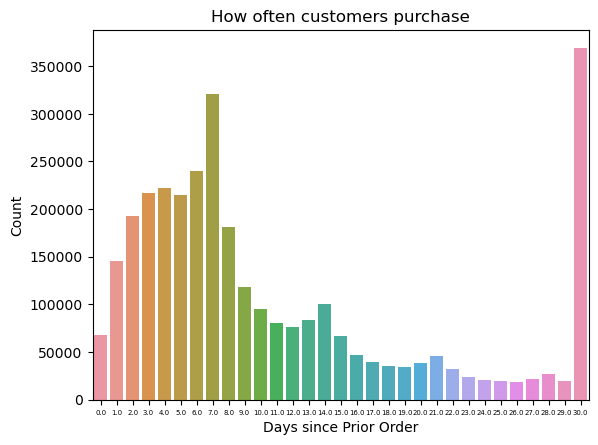

In [39]:
# Customer Purchase Frequency

order_frequency = orders.groupby("order_id")["days_since_prior_order"].max().reset_index()

plt.figure()
sns.countplot(order_frequency, x='days_since_prior_order')
plt.xlabel("Days since Prior Order")
plt.ylabel("Count")
plt.xticks(fontsize=5)
plt.title("How often customers purchase")
plt.show()

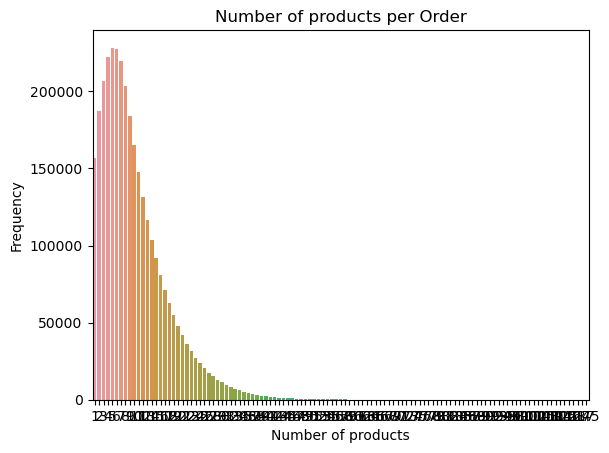

In [40]:
# Basket Size
products_bis = pd.merge(order_products_prior, products, on="product_id")
product_amount_per_order = products_bis.groupby("order_id")["add_to_cart_order"].max().reset_index()

plt.figure()
sns.countplot(product_amount_per_order, x="add_to_cart_order")
plt.title("Number of products per Order")
plt.xlabel("Number of products")
plt.ylabel("Frequency")

#del(products_bis)
plt.show()


In [41]:
products

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49685,49686,Artisan Baguette,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8


<Axes: xlabel='aisle_id', ylabel='order_id'>

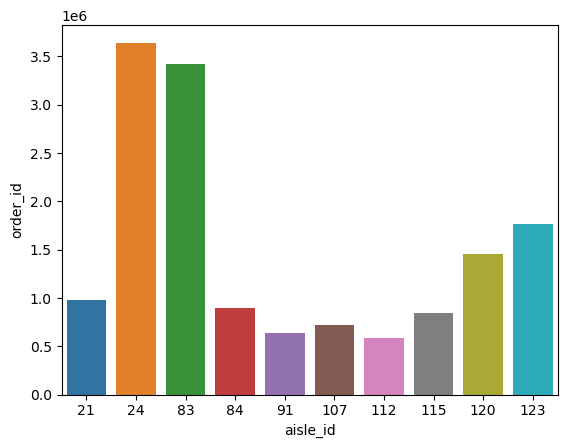

In [42]:
# top departments

top_aisle_in_one_order=products_bis.groupby("aisle_id")["order_id"].count().reset_index()
top_aisle_in_one_order = top_aisle_in_one_order.nlargest(10, "order_id")


plt.figure()
sns.barplot(data=top_aisle_in_one_order, x='aisle_id', y='order_id')

Ok, let's stop for a second to recap what we have found so far:
- Most of our clients have performed **in between 4 and 15 orders**. After that, the number of clients that have make more than 15 orders decreases exponentially. Worth mentioning that we have **almost no clients that have made just one or two orders**, which is a good sign. Also, it is interesting to see that there is a **peak at 100 orders**, which could be a good indicator of the number of orders that a client makes in a year.
- The **most popular days of the week are 0 and then 1** (they could be saturday and sunday, that's a conclusion extracted from the Kaggle discusion)
- The **most popular times of the day are precisely those during the day**. As the sunset approaches, orders are reduced, presenting minimums during the night and reactivating at dawn. 

In [43]:
#Now, we will append orders_products_prior with orders_products_train
orders_products = pd.concat([order_products_prior, order_products_train], axis=0)

In [44]:
#We will convert the order_id and product_id to object, and reordered to a boolean
orders_products.order_id = orders_products.order_id.astype(object)
orders_products.product_id = orders_products.product_id.astype(object)
orders_products.reordered = orders_products.reordered.astype(bool)

In [45]:
#Now, we will merge products, aisles and departments 
products_detailed = pd.merge(products, aisles, on='aisle_id', how='left')
products_detailed = pd.merge(products_detailed, departments, on='department_id', how='left')


In [46]:
#We will convert product_id, aisle_id and department_id to object
products_detailed.product_id = products_detailed.product_id.astype(object)
products_detailed.aisle_id = products_detailed.aisle_id.astype(object)
products_detailed.department_id = products_detailed.department_id.astype(object)

In [47]:
products_detailed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  object
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  object
 3   department_id  49688 non-null  object
 4   aisle          49688 non-null  object
 5   department     49688 non-null  object
dtypes: object(6)
memory usage: 2.3+ MB


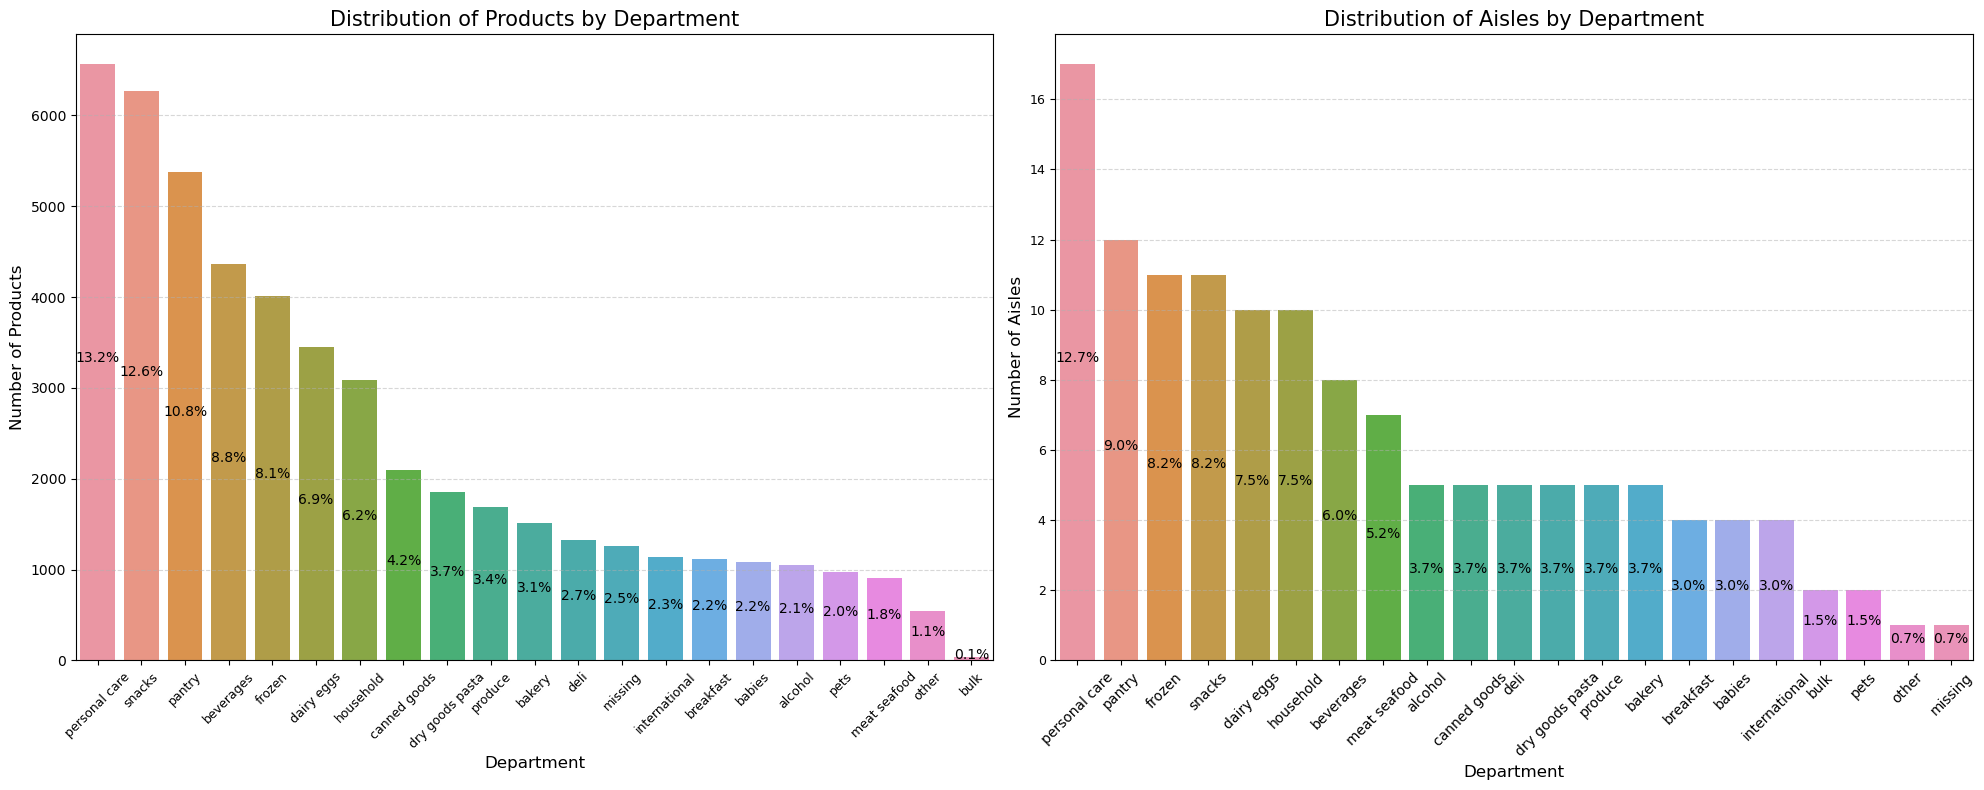

In [48]:
#Now, let's plot a graph to check the number of products in each department and another one to check the number of products in each aisle
#Graph 1: Distribution of Products by Department
products_per_department = products_detailed['department'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)  # Create the left subplot
sns.barplot(x=products_per_department.index, y=products_per_department.values)

plt.xlabel('Department', fontsize=12)
plt.ylabel('Number of Products', fontsize=12)
plt.title('Distribution of Products by Department', fontsize=15)

plt.xticks(fontsize=9, rotation=45)
plt.yticks(fontsize=10)

#Add a percentage label to each bar
for i in range(len(products_per_department)):
    count = products_per_department[i]
    pct_string = '{:0.1f}%'.format(100*count/products_per_department.sum())
    plt.text(i, count/2, pct_string, ha='center', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.5)

#Graph 2: Distribution of Aisles by Department
aisles_per_department = products_detailed.groupby('department')['aisle'].nunique().sort_values(ascending=False)

plt.subplot(1, 2, 2)  # Create the right subplot
sns.barplot(x=aisles_per_department.index, y=aisles_per_department.values)

plt.xlabel('Department', fontsize=12)
plt.ylabel('Number of Aisles', fontsize=12)
plt.title('Distribution of Aisles by Department', fontsize=15)

plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=9)

#Add a percentage label to each bar
for i in range(len(aisles_per_department)):
    count = aisles_per_department[i]
    pct_string = '{:0.1f}%'.format(100*count/aisles_per_department.sum())
    plt.text(i, count/2, pct_string, ha='center', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.5)


plt.tight_layout()
plt.show()


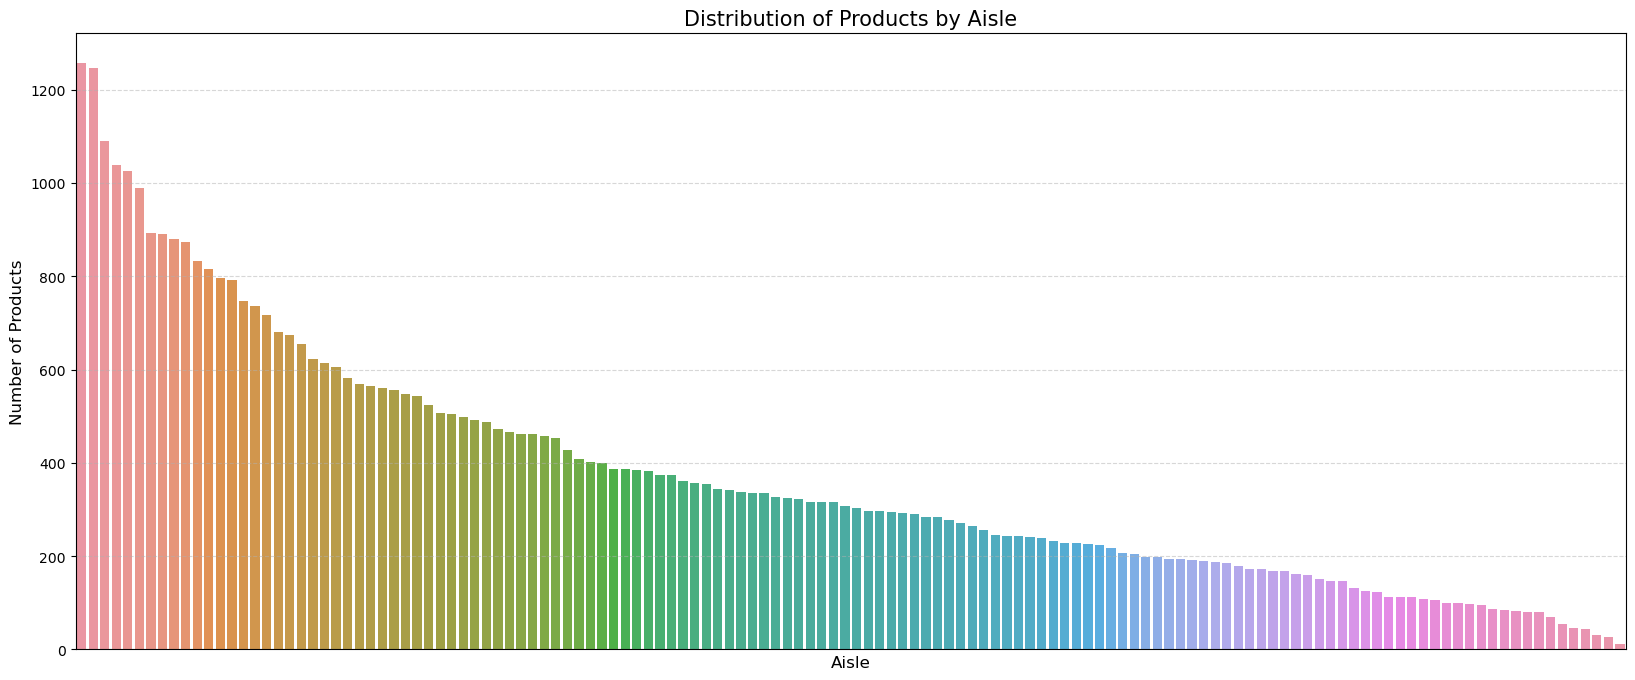

In [49]:
#We will plot a graph to check the number of products in each aisle
products_per_aisle = products_detailed['aisle'].value_counts().sort_index()
products_per_aisle = products_per_aisle.sort_values(ascending=False)

plt.figure(figsize=(20, 8))
sns.barplot(x=products_per_aisle.index, y=products_per_aisle.values)

plt.xlabel('Aisle', fontsize=12)
plt.ylabel('Number of Products', fontsize=12)
plt.title('Distribution of Products by Aisle', fontsize=15)

plt.yticks(fontsize=10)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.grid(axis='y', linestyle='--', alpha=0.5)


plt.show()

Some insights gained:
- **There are departments that have much more products than others.** 5 departments out of 21 (personal care, snacks, pantry, beverages and frozen) represent more than 50% of the products in the catalog
- Regarding the aisles per department, the distribution is simmilar to the prior ones, with some differences which are probably related to products size and storing needs and, specially, to number of items of each product
- The number of products in each aisle does not follow a special pattern, so we can find aisles with more than 1000 products and aisles with less than 10 products. This is probably (also) related to the size of the products and the storing needs.

In [50]:
#Now, let's merge orders_products with products_detailed
orders_detailed = pd.merge(orders_products, products_detailed, on='product_id', how='left')


In [51]:
orders_detailed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33819106 entries, 0 to 33819105
Data columns (total 9 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   order_id           object
 1   product_id         object
 2   add_to_cart_order  int64 
 3   reordered          bool  
 4   product_name       object
 5   aisle_id           object
 6   department_id      object
 7   aisle              object
 8   department         object
dtypes: bool(1), int64(1), object(7)
memory usage: 2.0+ GB


We are not going to add the orders dataset to the combined dataset at this point, but later, as there is plenty of granularity in the orders_detailed dataset.

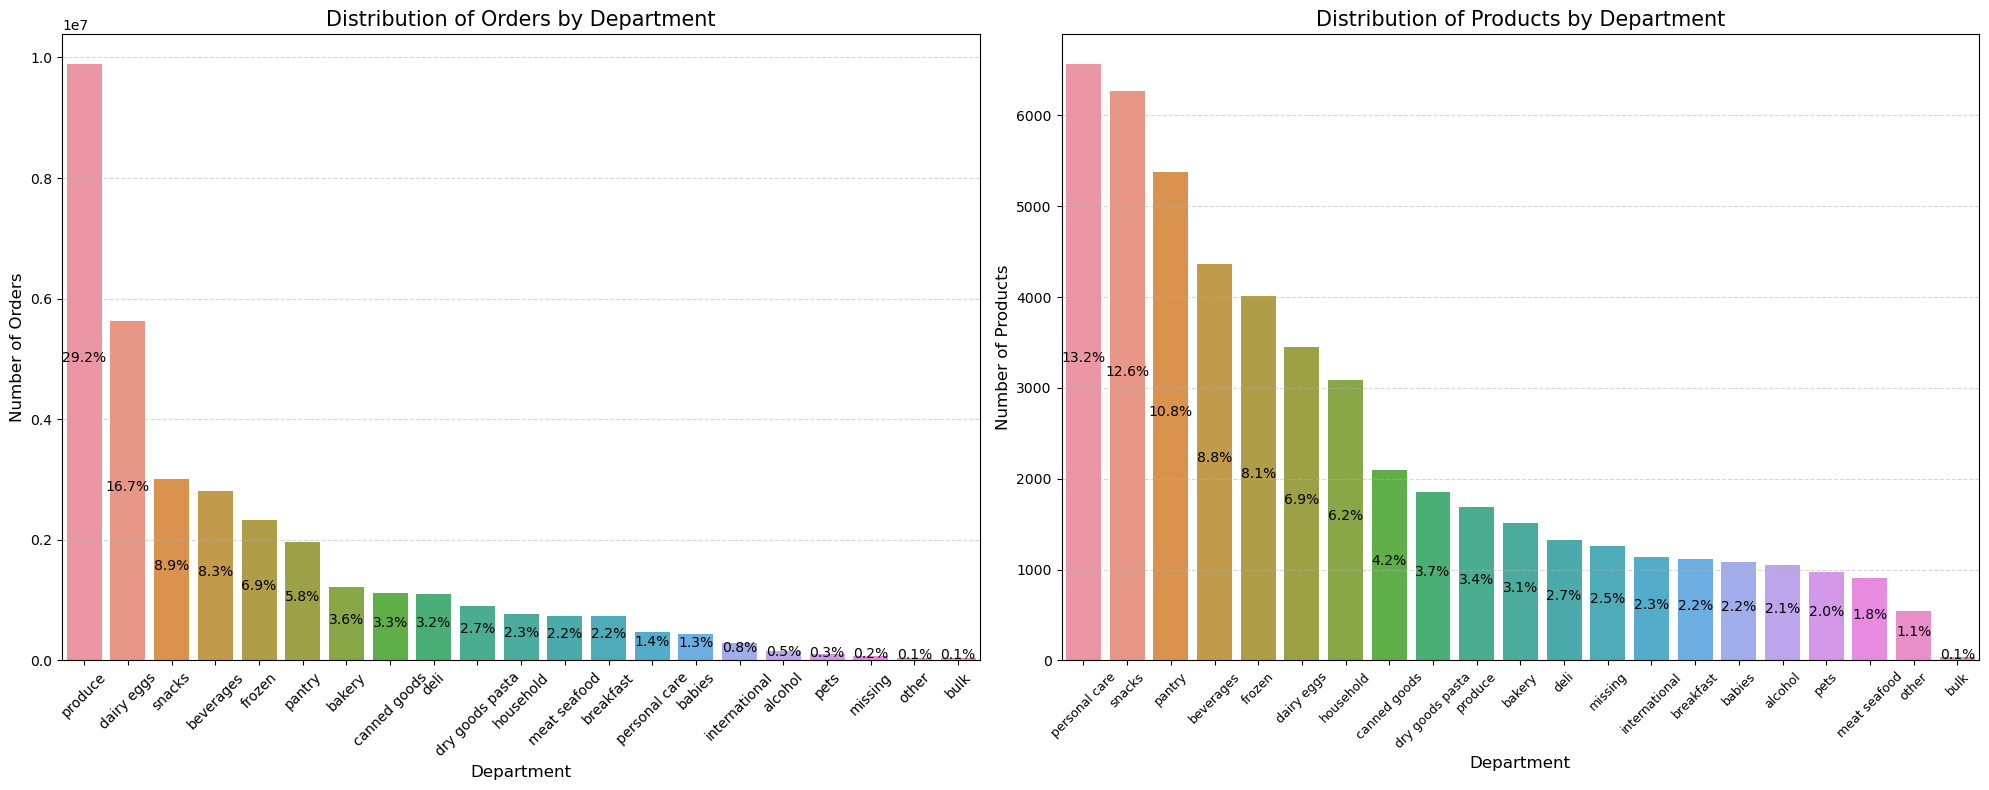

In [52]:
#Let's check the department with the most appearances in orders (after checking the graph, I have decided to plot it again with the previously made regarding product catalog)
department_most_orders = orders_detailed['department'].value_counts().sort_values(ascending=False)

#Graph 1: Distribution of Ordered items by Department
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)  # Create the left subplot
sns.barplot(x=department_most_orders.index, y=department_most_orders.values)

plt.xlabel('Department', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.title('Distribution of Orders by Department', fontsize=15)

plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)

#Add a percentage label to each bar
for i in range(len(department_most_orders)):
    count = department_most_orders[i]
    pct_string = '{:0.1f}%'.format(100*count/department_most_orders.sum())
    plt.text(i, count/2, pct_string, ha='center', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.5)

#Graph 2: Distribution of Products by Department
products_per_department = products_detailed['department'].value_counts().sort_values(ascending=False)

plt.subplot(1, 2, 2)  
sns.barplot(x=products_per_department.index, y=products_per_department.values)

plt.xlabel('Department', fontsize=12)
plt.ylabel('Number of Products', fontsize=12)
plt.title('Distribution of Products by Department', fontsize=15)

plt.xticks(fontsize=9, rotation=45)
plt.yticks(fontsize=10)

#Add a percentage label to each bar
for i in range(len(products_per_department)):
    count = products_per_department[i]
    pct_string = '{:0.1f}%'.format(100*count/products_per_department.sum())
    plt.text(i, count/2, pct_string, ha='center', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.5)


plt.tight_layout()
plt.show()

This visualization is pretty cool, as it allows us to observe many interesting elements:
- We can see that **"Produce"** whose products represent 3.4% of the catalog, represents no less than almost 30% of sales!
- On the other hand, **personal care**, which has the strongest presence in the catalog, with the greatest diversity of products, represents a residual percentage of sales, at least in volume. It may be that it has a benefit that we do not yet know, or that the selling price is high, allowing a good margin.

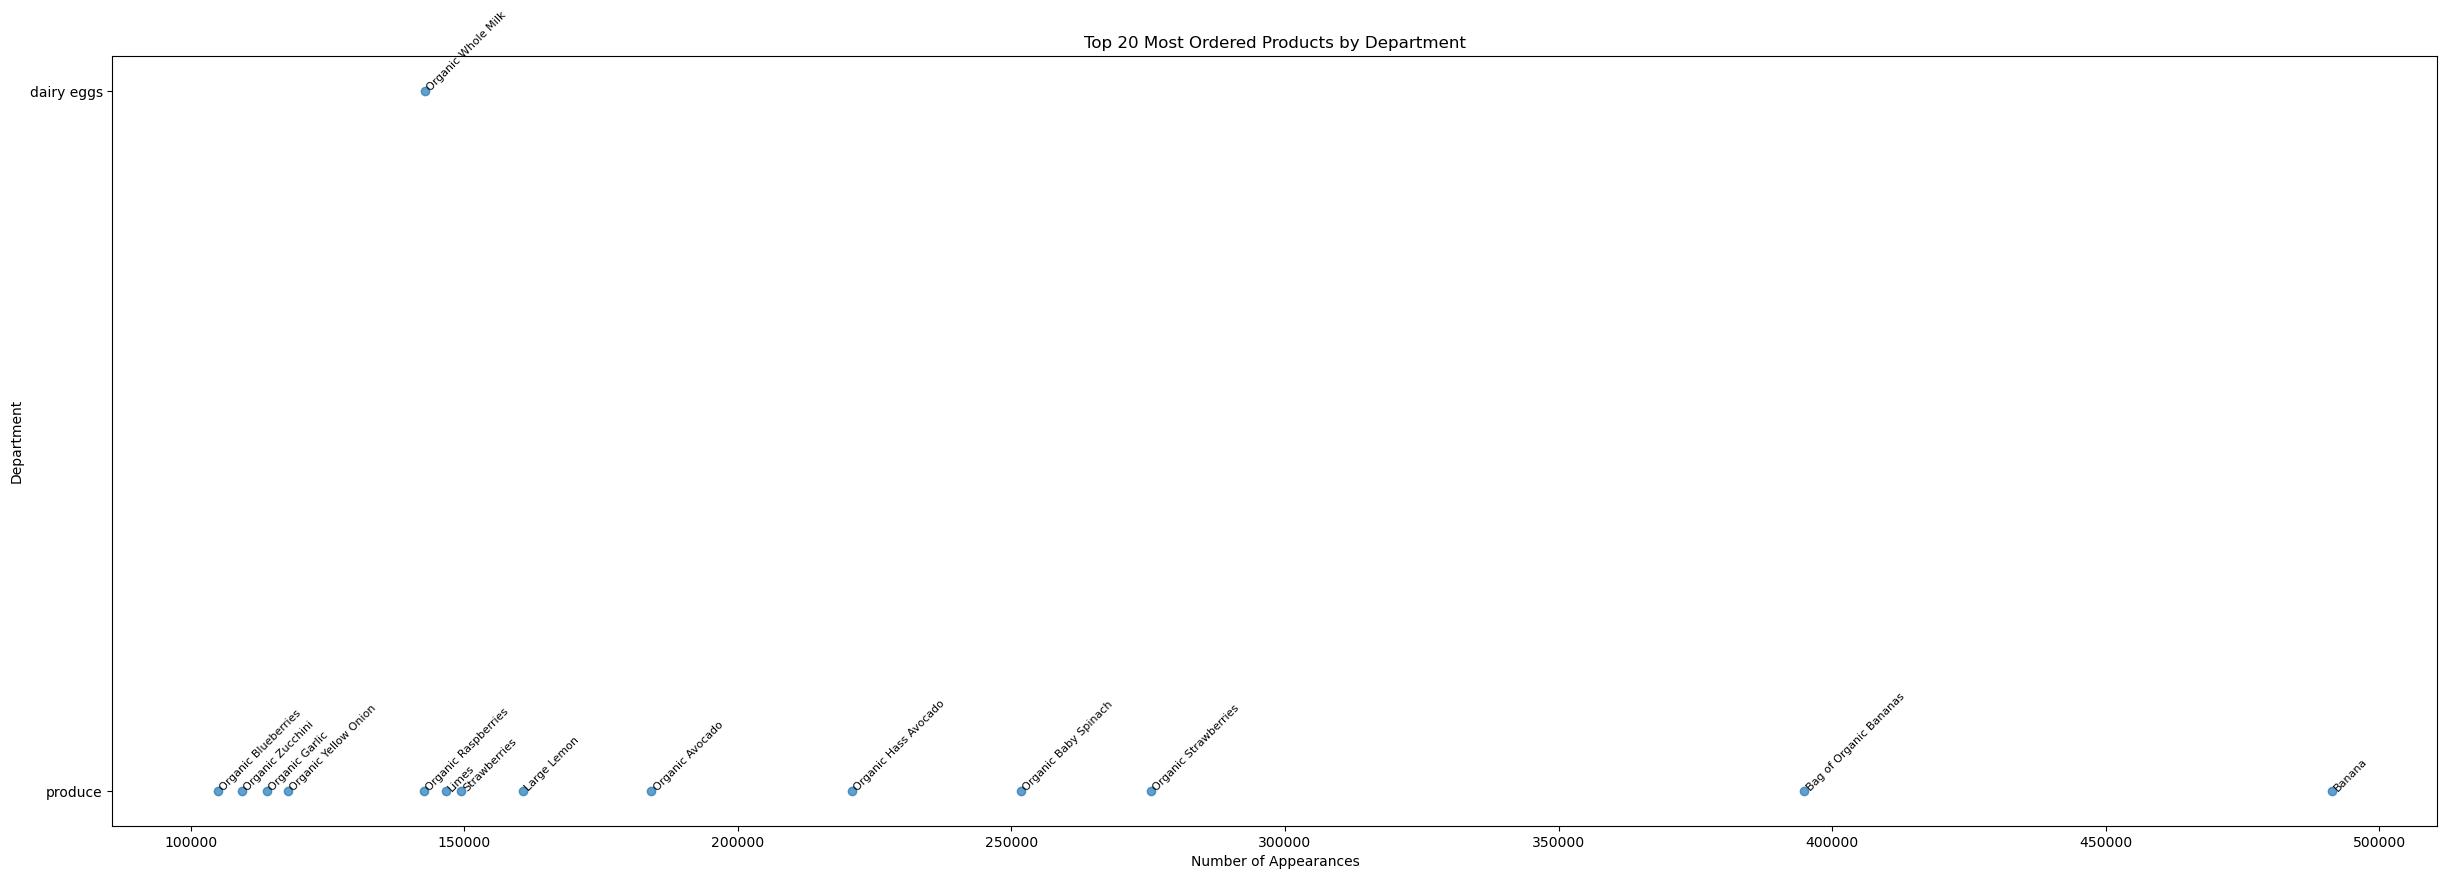

In [53]:
#Now we will plot a do graph to check, for the top 15 products, the number of appearances in orders and to which department they belong

product_counts = orders_detailed.groupby(['product_name', 'department']).size().reset_index(name='counts')
top_products = product_counts.nlargest(15, 'counts')

plt.figure(figsize=(30, 10))

plt.scatter(top_products['counts'], top_products['department'], alpha=0.7)

for i, row in top_products.iterrows():
    plt.text(row['counts'], row['department'], row['product_name'], fontsize=8, ha='left',rotation=45)

plt.xlabel('Number of Appearances')
plt.ylabel('Department')
plt.title('Top 20 Most Ordered Products by Department')

plt.show()

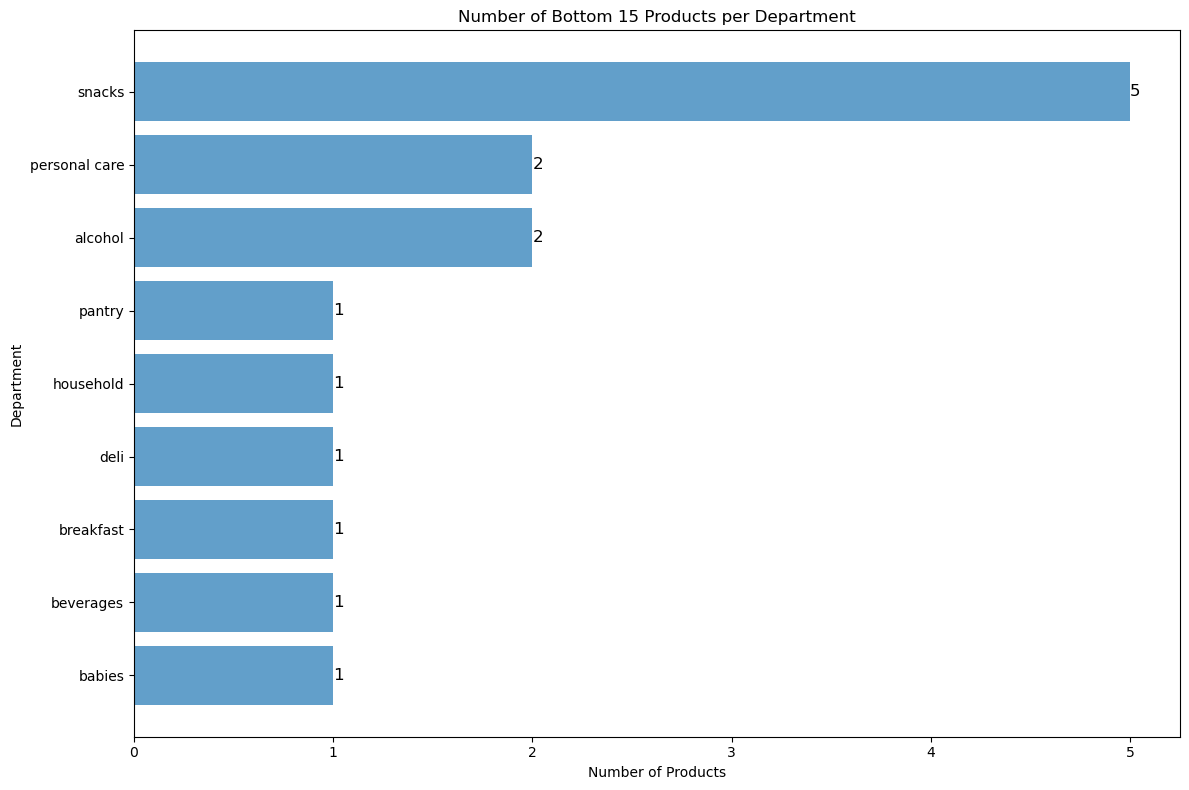

In [54]:
#And at this point we will do the same for the bottom 15 products. After plotting a dot graph, we hace decided to plot a bar graph to make it more readable for these products
product_counts = orders_detailed.groupby(['product_name', 'department']).size().reset_index(name='counts')
bottom_products = product_counts.nsmallest(15, 'counts')

department_counts = bottom_products.groupby('department').size().reset_index(name='product_count').sort_values('product_count', ascending=True)

plt.figure(figsize=(12, 8))

plt.barh(department_counts['department'], department_counts['product_count'], alpha=0.7)

plt.xlabel('Number of Products')
plt.ylabel('Department')
plt.title('Number of Bottom 15 Products per Department')

for i, row in department_counts.iterrows():
    plt.text(row['product_count'], row['department'], row['product_count'], fontsize=12, va='center')

plt.tight_layout()

plt.show()

In [55]:
# Let's keep orders_detailed for later and future notebooks
orders_detailed.to_csv('./data/orders_detail.csv')

In [56]:
orders_detailed.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,True,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,True,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,False,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,True,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,False,Natural Sweetener,17,13,baking ingredients,pantry


In [57]:
import session_info
session_info.show(html=False)

-----
matplotlib          3.7.2
numpy               1.26.0
pandas              2.0.3
seaborn             0.12.2
session_info        1.0.0
tqdm                4.65.0
-----
IPython             8.15.0
jupyter_client      8.1.0
jupyter_core        5.3.0
-----
Python 3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:15:57) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.22631-SP0
-----
Session information updated at 2024-03-14 18:24
